In [1]:
import os
from PIL import Image
from torchvision import transforms
from torchvision import datasets, models, transforms
import sys
sys.path.append('../src')
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
import torch.nn.functional as F
import time
import copy
import PIL
from keras.models import Model

C:\ProgramData\Anacondas3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
SEED = 1080
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

In [3]:
path="../cate_and_dog/"

In [4]:
os.listdir(path)

['.ipynb_checkpoints',
 'cat and dog.ipynb',
 'model_resnet152_dog_cat.sav',
 'model_resnet18_cat_dog.sav',
 'ploting.py',
 'src',
 'train',
 'val',
 '__pycache__']

In [5]:
os.listdir(f'{path}train')

['cat', 'dog']

In [6]:
os.listdir(f'{path}val')

['cat', 'dog']

In [7]:
filename=os.listdir(f'{path}train/cat')[:10]
print(filename)

['12000.jpg', '12001.jpg', '12002.jpg', '12003.jpg', '12004.jpg', '12005.jpg', '12006.jpg', '12007.jpg', '12008.jpg', '12009.jpg']


In [8]:
image=Image.open(f'{path}/train/cat/{filename[0]}')
image.show()                   

In [9]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [10]:
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),transform[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) 
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

['cat', 'dog']


In [11]:
size={y:len(image_datasets[y]) for y in ['val']}

In [ ]:
size

In [12]:
  model_resnet18 = models.resnet18(pretrained=True)
print(model_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [13]:
def inverse_transform(inp):
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    return inp

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inverse_transform(inp)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=10)
    plt.axis('off')

In [15]:
from ploting import *
%matplotlib inline

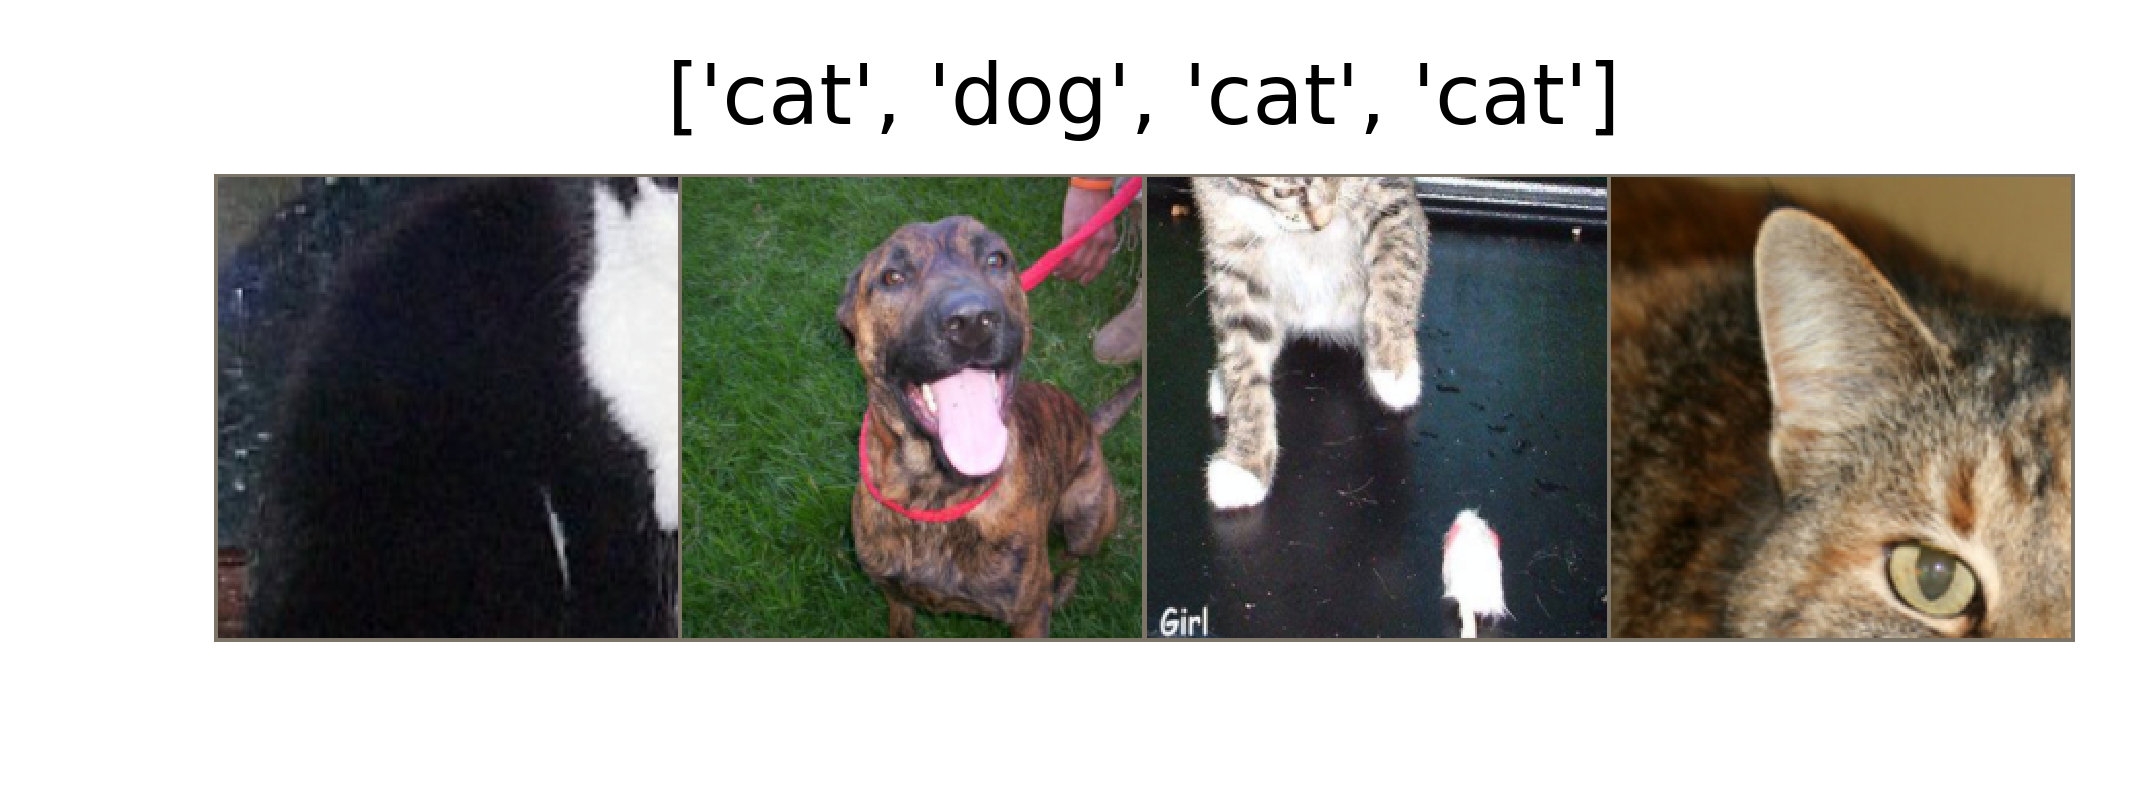

In [16]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

beatify(fig_width=4)
imshow(out, title=[class_names[x] for x in classes])

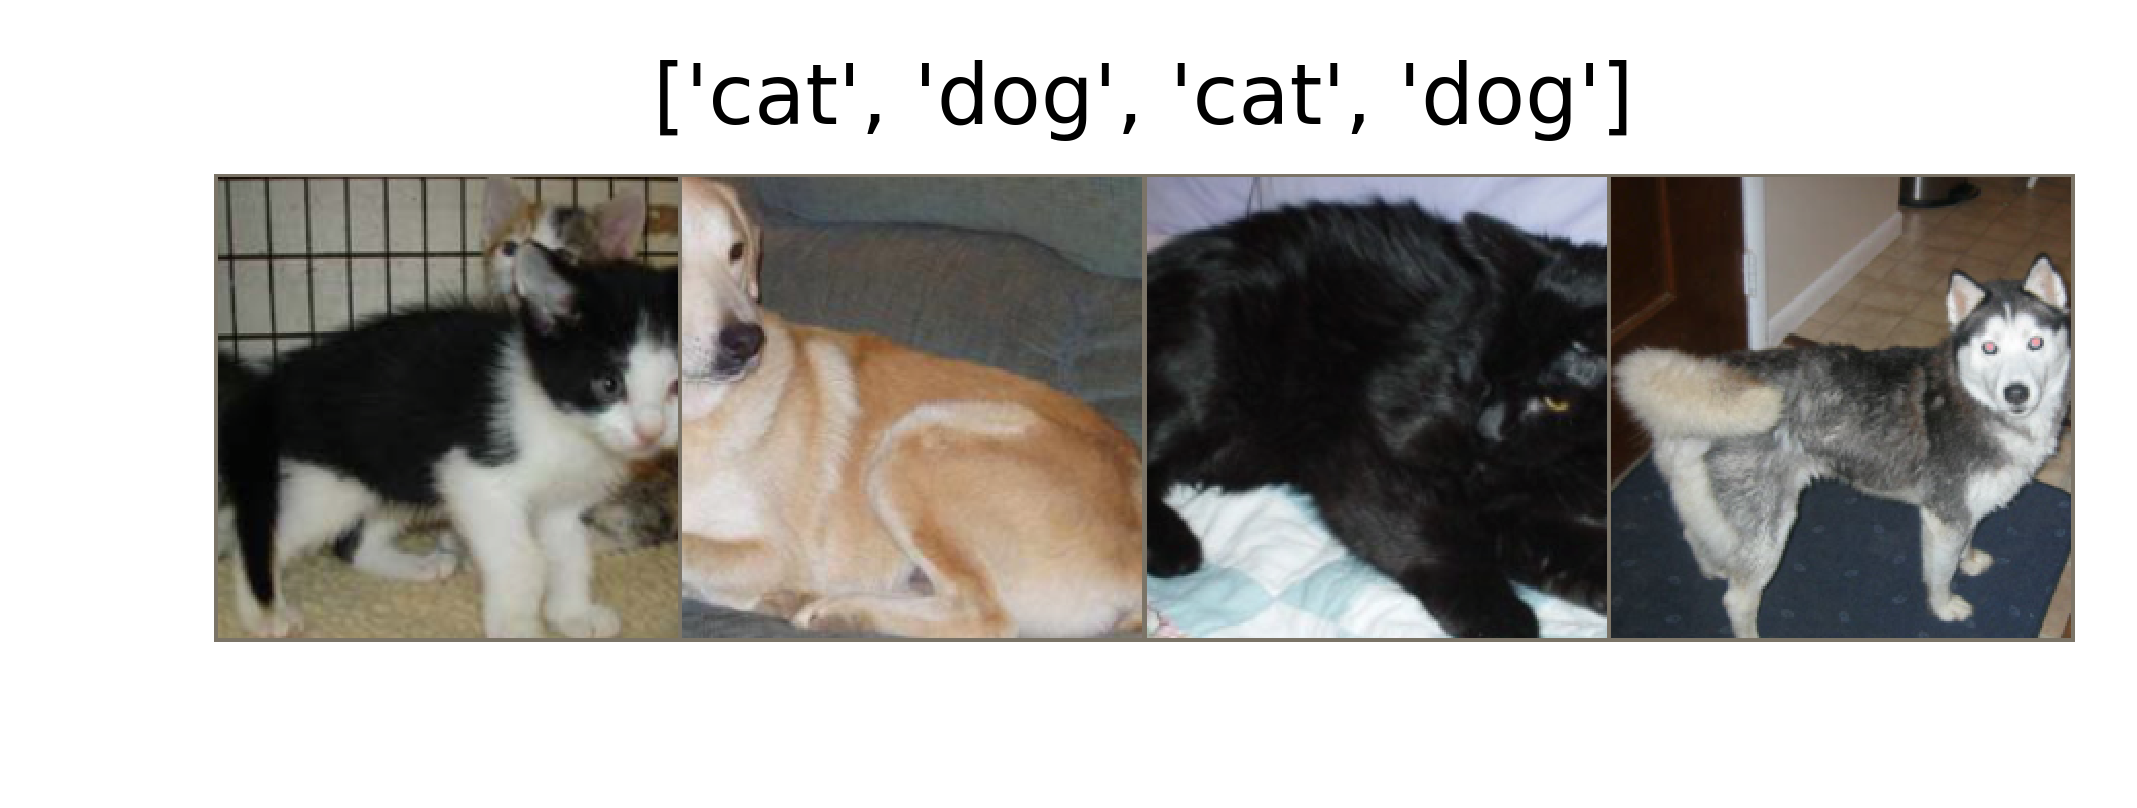

In [17]:
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

beatify(fig_width=4)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
number_feature=model_resnet18.fc.in_features

In [ ]:
model_resnet18.fc=nn.Linear(number_feature,2)

In [ ]:
print(model_resnet18)

In [24]:
criterion = nn.CrossEntropyLoss() 

In [25]:
optimizer_rsnet18 = torch.optim.SGD(model_resnet18.parameters(), lr=0.001, momentum=0.9 )

In [26]:
 from torch.optim import lr_scheduler
# Decay LR by a factor of 0.1 every 2 epochs
scheduler_lr = lr_scheduler.StepLR(optimizer_rsnet18 , step_size=5)

In [ ]:
#if torch.cuda.is_available():
 #   model_resnet50 = model_resnet50.cuda()
  #  criterion = criterion.cuda()

In [27]:
def fit_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                #if torch.cuda.is_available():
                  #  inputs = Variable(inputs.cuda())
                   # labels = Variable(labels.cuda())
                #else:
                inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.item() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [31]:
model_best = fit_model(model_resnet18, criterion, optimizer_rsnet18,  scheduler_lr, dataloaders, num_epochs=5)

Epoch 1/5
----------


C:\ProgramData\Anacondas3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


train Loss: 1.7552 Acc: 0.6461
val Loss: 0.4578 Acc: 0.8700

Epoch 2/5
----------
train Loss: 0.4174 Acc: 0.8242
val Loss: 0.3166 Acc: 0.9200

Epoch 3/5
----------
train Loss: 0.3718 Acc: 0.8413
val Loss: 0.2371 Acc: 0.9350

Epoch 4/5
----------
train Loss: 0.4043 Acc: 0.8390
val Loss: 0.2024 Acc: 0.9450

Epoch 5/5
----------
train Loss: 0.3433 Acc: 0.8470
val Loss: 0.1771 Acc: 0.9500

Training complete in 34m 1s
Best val Acc: 0.950000


In [32]:
#save model in harddisk 
from sklearn.externals import joblib
filename="model_resnet18_cat_dog.sav"
joblib.dump(model_best,filename)


['model_resnet18_cat_dog.sav']

In [33]:
from sklearn.externals import joblib
filename="model_resnet18_cat_dog.sav"
#load the model from the hard disk
loaded_model=joblib.load(filename)

In [ ]:
def visualize_model(model, num_images=6):
    
    training_mode = model.training
    model.eval()
    images_so_far = 0
    

    for i, data in enumerate(dataloaders['val']):
        
        inputs, labels = data
        
            #inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        #else:
        inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            plt.subplot(2, int(num_images/2), images_so_far)
            plt.imshow(inverse_transform(inputs.cpu().data[j]))
            plt.title('predicted: {}'.format(class_names[preds[j]]), fontsize=8)
            plt.tight_layout()
            plt.xticks([])
            plt.yticks([])
            #ax.axis('off')
    
            if images_so_far == num_images:
                model.train(mode=training_mode)
                return
    model.train(mode=training_mode)

In [ ]:
beatify(fig_width=4)
visualize_model(model_best)

The resnet152 is the best model for challenge which involed cancer which condaucted on 2018

In [18]:
model_resnet152=models.resnet152(pretrained=True)

In [19]:
print(model_resnet152)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [20]:
number_feature=model_resnet152.fc.in_features

In [21]:
model_resnet152.fc=nn.Linear(number_feature,2)

In [22]:
optimizer_rsnet152 = torch.optim.SGD(model_resnet152.parameters(), lr=0.001, momentum=0.9 )

In [28]:
model_better=fit_model(model_resnet152, criterion, optimizer_rsnet152,  scheduler_lr, dataloaders, num_epochs=5)

Epoch 1/5
----------


C:\ProgramData\Anacondas3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


train Loss: 0.4539 Acc: 0.8162
val Loss: 0.0872 Acc: 0.9700

Epoch 2/5
----------
train Loss: 0.4966 Acc: 0.8082
val Loss: 0.8521 Acc: 0.7750

Epoch 3/5
----------
train Loss: 0.4088 Acc: 0.8459
val Loss: 0.1489 Acc: 0.9500

Epoch 4/5
----------
train Loss: 0.2932 Acc: 0.8779
val Loss: 0.2117 Acc: 0.9200

Epoch 5/5
----------
train Loss: 0.2355 Acc: 0.9030
val Loss: 0.1156 Acc: 0.9600

Training complete in 156m 7s
Best val Acc: 0.970000


In [29]:
#save model in harddisk 
from sklearn.externals import joblib
filename="model_resnet152_dog_cat.sav"
joblib.dump(model_better,filename)


['model_resnet152_dog_cat.sav']

In [30]:
from sklearn.externals import joblib
filename="model_resnet152_dog_cat.sav"
#load the model from the hard disk
loaded_model=joblib.load(filename)

resnext model 

In [ ]:
beatify(fig_width=4)
visualize_model(model_better)